#**teeth classification model by using pre-trained model "VGG16" update from using base model to apply trandfer learning**

#load data from drive

In [1]:
!pip install gdown
import gdown

In [2]:
file_id = "1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
url = f"https://drive.google.com/uc?id={file_id}"
output = "teeth_Dataset.zip"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=7f10f9aa-5cf2-4313-a34a-8c8e19873aba
To: /content/teeth_Dataset.zip
100%|██████████| 49.1M/49.1M [00:01<00:00, 29.4MB/s]


'teeth_Dataset.zip'

In [3]:
import zipfile
import os

zip_path = "/content/teeth_Dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir("/content/"))

['.config', 'teeth_Dataset.zip', 'Teeth_Dataset', 'sample_data']


In [4]:
print(os.listdir("/content/Teeth_Dataset/Testing"))

['CaS', 'OC', 'Gum', 'OT', 'outputs', 'MC', 'output', 'output_image.jpg', 'OLP', 'CoS', 'out']


In [5]:
!rm -r /content/Teeth_Dataset/Testing/outputs
!rm -r /content/Teeth_Dataset/Testing/output
!rm -r /content/Teeth_Dataset/Testing/out
!rm -r /content/Teeth_Dataset/Testing/output_image.jpg

In [6]:
print(os.listdir("/content/Teeth_Dataset/Testing"))

['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']


#image preprocessing and augmentation

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

In [8]:
import random
img_size=(224,224)
batch_size=32
num_classes=7
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
train_dirc = "/content/Teeth_Dataset/Training"
val_dirc = "/content/Teeth_Dataset/Validation"
test_dirc = "/content/Teeth_Dataset/Testing"

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dirc,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed)
val_generator = validation_datagen.flow_from_directory(
    val_dirc,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed)
test_generator = test_datagen.flow_from_directory(
    test_dirc,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


#build the model (VGG16) arch with feature extaraction to last layer

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

**Load the VGG16 model with pre-trained ImageNet weights**

In [12]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


**Freeze the convolutional base to prevent its weights from being updated**

In [13]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

**my custom classifier**

In [14]:
x = base_model.output
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,839 (62.26 MB)

 Trainable params: 16,320,839 (62.26 MB)

 Non-trainable params: 0 (0.00 B)

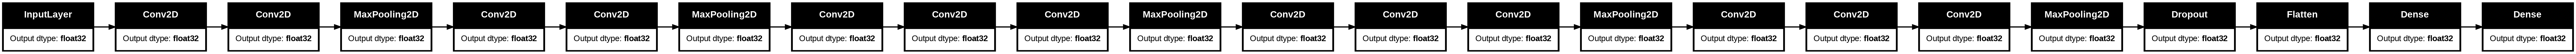

In [16]:
tf.keras.utils.plot_model(model,rankdir="LR",show_dtype=True)

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-5)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # File path to save the model
    save_best_only=True,         # Only save the model if `val_accuracy` has improved
    monitor='val_accuracy',      # The metric to monitor
    mode='max',                  # 'max' because we want to maximize accuracy
    verbose=1                    # Prints a message when the model is saved
)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [20]:
history_fine_tune = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback,early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.2194 - loss: 1.9430
Epoch 1: val_accuracy improved from -inf to 0.46206, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.2200 - loss: 1.9419 - val_accuracy: 0.4621 - val_loss: 1.5058
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.4231 - loss: 1.4897
Epoch 2: val_accuracy improved from 0.46206 to 0.63619, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 628ms/step - accuracy: 0.4234 - loss: 1.4891 - val_accuracy: 0.6362 - val_loss: 1.0621
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5493 - loss: 1.2124
Epoch 3: val_accuracy improved from 0.63619 to 0.69942, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 66s 683ms/step - accuracy: 0.5492 - loss: 1.2123 - val_accuracy: 0.6994 - val_loss: 0.8411
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.6274 - loss: 1.0335
Epoch 4: val_accuracy improved from 0.69

In [21]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Args:
      history: The history object returned from model.fit().
    """
    # Extracting accuracy and loss values from the history object
    acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']
    loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']

    epochs_range = range(len(acc))

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Subplot for Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Subplot for Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Display the plots
    plt.show()

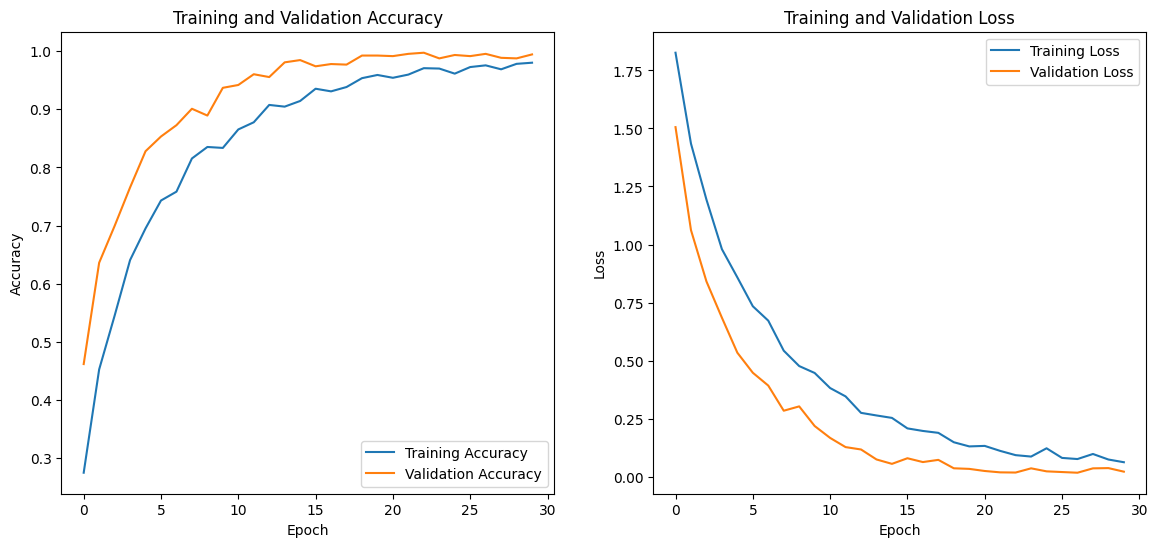

In [22]:
plot_training_history(history_fine_tune)

#Load Best Model

In [29]:
best_model = tf.keras.models.load_model('best_model.keras')

In [30]:
loss, accuracy = best_model.evaluate(test_generator)

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {loss}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9963 - loss: 0.0121
Final Test Accuracy: 99.22%
Final Test Loss: 0.02353425696492195


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions from the model
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step
Classification Report
              precision    recall  f1-score   support

         CaS       0.99      1.00      0.99       160
         CoS       0.99      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      0.98      0.99       180
          OC       0.98      0.97      0.98       108
         OLP       0.99      0.99      0.99       180
          OT       1.00      0.99      1.00       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028

Confusion Matrix
[[160   0   0   0   0   0   0]
 [  0 149   0   0   0   0   0]
 [  0   0 120   0   0   0   0]
 [  0   1   0 177   2   0   0]
 [  0   0   0   2 105   1   0]
 [  1   0   0   0   0 179   0]
 [  1   0   0   0   0   0 130]]


In [32]:
best_model.save('teeth_best_model_vgg16.h5')

print("Model successfully saved as teeth_best_model_vgg16.h5")

Model successfully saved as teeth_best_model_vgg16.h5
